40
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Epoch:1/51 Error:5.119472604652017


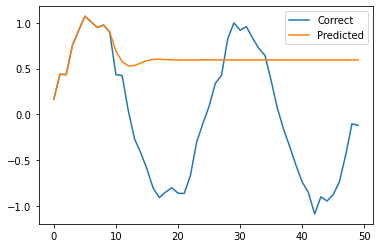

Epoch:6/51 Error:1.5677856222583595


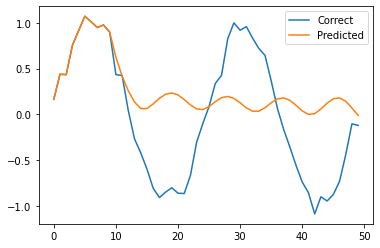

Epoch:11/51 Error:0.6938527027752084


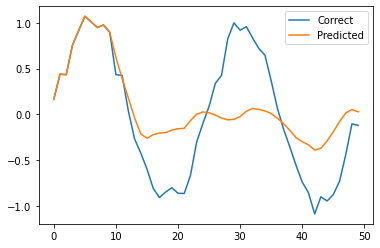

Epoch:16/51 Error:0.46058403891500355


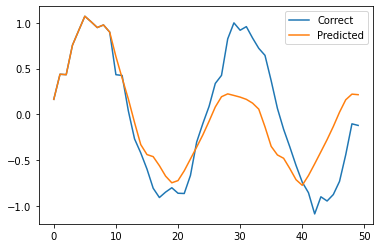

Epoch:21/51 Error:0.3938570122929015


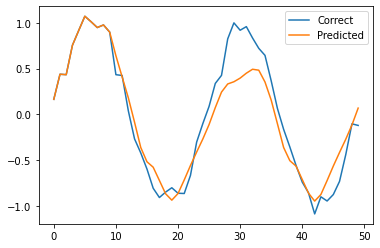

Epoch:26/51 Error:0.3708450298040574


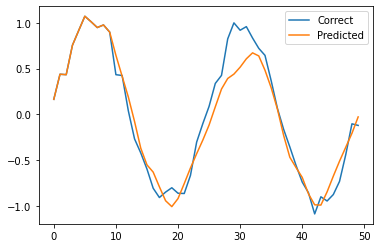

Epoch:31/51 Error:0.35944980730578513


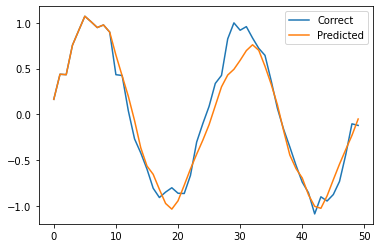

Epoch:36/51 Error:0.35166948610279625


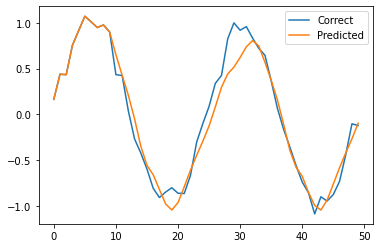

Epoch:41/51 Error:0.345329248007914


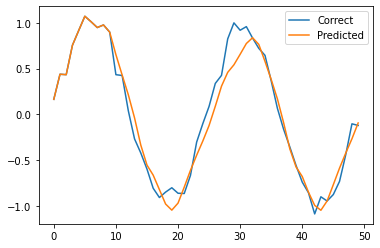

Epoch:46/51 Error:0.3398311177144043


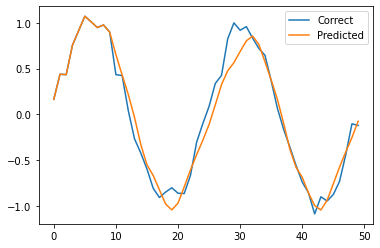

Epoch:51/51 Error:0.3348181050759347


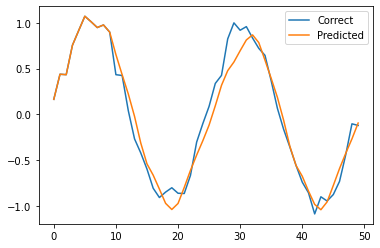

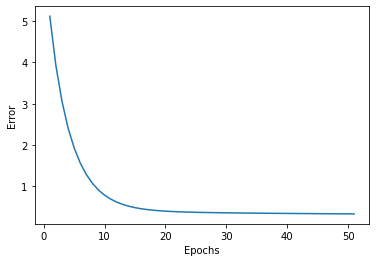

In [4]:
import numpy as np
# import cupy as np     # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt

# -- 각 설정 값 --
n_time = 10    # 시점 수
n_in = 1       # 입력층 뉴런 수
n_mid = 20     # 은닉층 뉴런 수
n_out = 1      # 출력층 뉴런 수

eta = 0.001    # 학습률
epochs = 51
batch_size = 8
interval = 5   # 경과 표시 간격

# -- 훈련 데이터 생성 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)    # -2*pi에서 2*pi까지
# sin 함수에 무작위로 노이즈 생성하기
sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))

n_sample = len(sin_x)-n_time                      # 샘플 수
input_data = np.zeros((n_sample, n_time, n_in))   # 입력
correct_data = np.zeros((n_sample, n_out))        # 정답

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    # 정답은 입력보다 한 시점 뒤
    correct_data[i] = sin_y[i+n_time:i+n_time+1]


# -- RNN층 --
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 파라미터 초깃값 설정
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(n,n) / np.sqrt(n)
        self.b = np.zeros(n)
        
    def forward(self, x, y_prev):    # y_prev: 이전 시점의 출력
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)          # 출력
        
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)
        
        # 각 기울기
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)
        
    def rest_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b
        
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u    # 항등함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 각 층의 초기화 --
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 RNN층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:,i+1,:] = y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    
    # 역전파 RNN층
    rnn_layer.rest_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev
        
    # 파라미터 갱신
    rnn_layer.update(eta)
    output_layer.update(eta)
    
# -- 예측 --
def predict(x_mb):
    # 순전파 RNN층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y-t))    # 오차제곱합

error_record = []
n_batch = len(input_data) // batch_size       # 1에포크당 배치 개수
for i in range(epochs):
    
    # -- 학습 --
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)           # 인덱스 임의 섞기
    for j in range(n_batch):
        # 미니 배치 데이터 훈련
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
        
    # -- 오차 구하기 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs),
             "Error:"+str(error))
        predicted = input_data[0].reshape(-1).tolist()    # 최초 입력
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1,n_time, 1)
            y = predict(x)
            # 출력을 predicted에 추가하기
            predicted.append(float(y[0,0]))

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
    
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()